In [1]:
%load_ext autoreload
%autoreload 2

# Individual City Regression


In [2]:
# ruff: noqa: E402
import os
import sys
from pathlib import Path

# add the
ROOT = Path(os.getcwd())
while not (ROOT / ".git").exists():
    ROOT = ROOT.parent

sys.path.append(str(ROOT))

import polars as pl
import numpy as np
import pandas as pd
from srai.plotting.folium_wrapper import plot_numeric_data

## Load the Service Time Datasets


In [3]:
from src.config import load_config


config = load_config(ROOT / "config" / "paper.yaml")

service_time_df = (
    pl.concat(
        (
            pl.scan_parquet(city.file).with_columns(
                pl.col(city.service_time_col).alias("service_time")
            )
            for city in config.ServiceTime
            if city.name == "amazon"
        )
    )
    .filter(pl.col("city").str.contains("Boston"))
    .collect()
)

In [4]:
service_time_df.head()

shape: (5, 23)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ stop_id ┆ route_id   ┆ station_c ┆ executor_ ┆ … ┆ arrival_d ┆ time_of_d ┆ city      ┆ service_t │
│ ---     ┆ ---        ┆ ode       ┆ capacity_ ┆   ┆ atetime   ┆ ay        ┆ ---       ┆ ime       │
│ str     ┆ str        ┆ ---       ┆ cm3       ┆   ┆ ---       ┆ ---       ┆ str       ┆ ---       │
│         ┆            ┆ str       ┆ ---       ┆   ┆ datetime[ ┆ u32       ┆           ┆ f64       │
│         ┆            ┆           ┆ f64       ┆   ┆ μs, EST]  ┆           ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ TM      ┆ RouteID_77 ┆ DBO3      ┆ 3.313071e ┆ … ┆ 2018-08-1 ┆ 31220     ┆ Boston,   ┆ 35.0      │
│         ┆ ad62b1-d7f ┆           ┆ 6         ┆   ┆ 5 08:40:2 ┆           ┆ USA       ┆           │
│         ┆ f-4bd2-ad0 ┆           ┆           ┆   ┆ 0.500 EST ┆           ┆           ┆           │
│         ┆ 6-…        ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ VA      ┆ RouteID_77 ┆ DBO3      ┆ 3.313071e ┆ … ┆ 2018-08-1 ┆ 31406     ┆ Boston,   ┆ 155.0     │
│         ┆ ad62b1-d7f ┆           ┆ 6         ┆   ┆ 5 08:43:2 ┆           ┆ USA       ┆           │
│         ┆ f-4bd2-ad0 ┆           ┆           ┆   ┆ 6.100 EST ┆           ┆           ┆           │
│         ┆ 6-…        ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ NL      ┆ RouteID_77 ┆ DBO3      ┆ 3.313071e ┆ … ┆ 2018-08-1 ┆ 31533     ┆ Boston,   ┆ 111.0     │
│         ┆ ad62b1-d7f ┆           ┆ 6         ┆   ┆ 5         ┆           ┆ USA       ┆           │
│         ┆ f-4bd2-ad0 ┆           ┆           ┆   ┆ 08:45:33  ┆           ┆           ┆           │
│         ┆ 6-…        ┆           ┆           ┆   ┆ EST       ┆           ┆           ┆           │
│ EC      ┆ RouteID_77 ┆ DBO3      ┆ 3.313071e ┆ … ┆ 2018-08-1 ┆ 31627     ┆ Boston,   ┆ 93.0      │
│         ┆ ad62b1-d7f ┆           ┆ 6         ┆   ┆ 5 08:47:0 ┆           ┆ USA       ┆           │
│         ┆ f-4bd2-ad0 ┆           ┆           ┆   ┆ 7.600 EST ┆           ┆           ┆           │
│         ┆ 6-…        ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
│ DT      ┆ RouteID_77 ┆ DBO3      ┆ 3.313071e ┆ … ┆ 2018-08-1 ┆ 31843     ┆ Boston,   ┆ 88.0      │
│         ┆ ad62b1-d7f ┆           ┆ 6         ┆   ┆ 5 08:50:4 ┆           ┆ USA       ┆           │
│         ┆ f-4bd2-ad0 ┆           ┆           ┆   ┆ 3.100 EST ┆           ┆           ┆           │
│         ┆ 6-…        ┆           ┆           ┆   ┆           ┆           ┆           ┆           │
└─────────┴────────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

### Group on Region and Calculate Probabilities


In [5]:
service_time_grouped = service_time_df.group_by("region_id").agg(
    (pl.col("service_time") >= (2.5 * 60)).mean().alias("p_greater_2.5"),
    (pl.col("service_time") >= (5 * 60)).mean().alias("p_greater_5"),
    (pl.col("service_time") >= (10 * 60)).mean().alias("p_greater_10"),
    pl.col("service_time").median().alias("median_service_time"),
    pl.count().alias("n"),
)

/var/folders/96/_9h8bqbx4gqcmb4td8q57q8w0000gn/T/ipykernel_28427/3674584061.py:6: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("n"),


### Convert to GeoPanadas Dataframe


In [6]:
import geopandas as gpd

h3_df = pd.concat(
    [gpd.read_parquet(city.h3_file).assign(city=city.name) for city in config.Cities],
    axis=0,
).query("is_city")

h3_df.head()

h3_df = h3_df.merge(service_time_grouped.to_pandas(), on="region_id")


h3_df = h3_df.set_index("region_id")

In [7]:
search_hexes = (
    service_time_grouped.filter(
        pl.col("region_id").is_in(h3_df.reset_index()["region_id"])
    )
    .with_columns((pl.col("median_service_time").rank() / pl.len()).alias("rank"))
    .filter(pl.col("n") >= 20)
)

In [8]:
targets = search_hexes.sort((pl.col("rank") - 0.05).abs()).head(5)
hex_low = targets["region_id"][0]
targets.head()

shape: (5, 7)
┌─────────────────┬───────────────┬─────────────┬──────────────┬─────────────────┬─────┬───────────┐
│ region_id       ┆ p_greater_2.5 ┆ p_greater_5 ┆ p_greater_10 ┆ median_service_ ┆ n   ┆ rank      │
│ ---             ┆ ---           ┆ ---         ┆ ---          ┆ time            ┆ --- ┆ ---       │
│ str             ┆ f64           ┆ f64         ┆ f64          ┆ ---             ┆ u32 ┆ f64       │
│                 ┆               ┆             ┆              ┆ f64             ┆     ┆           │
╞═════════════════╪═══════════════╪═════════════╪══════════════╪═════════════════╪═════╪═══════════╡
│ 892a3064babffff ┆ 0.2           ┆ 0.066667    ┆ 0.0          ┆ 55.5            ┆ 30  ┆ 0.050521  │
│ 892a306482bffff ┆ 0.233333      ┆ 0.1         ┆ 0.0          ┆ 55.5            ┆ 30  ┆ 0.050521  │
│ 892a30659b3ffff ┆ 0.15          ┆ 0.05        ┆ 0.0          ┆ 55.5            ┆ 20  ┆ 0.050521  │
│ 892a306483bffff ┆ 0.038462      ┆ 0.0         ┆ 0.0          ┆ 55.5            ┆ 26  ┆ 0.050521  │
│ 892a3066977ffff ┆ 0.185185      ┆ 0.037037    ┆ 0.0          ┆ 55.0            ┆ 27  ┆ 0.0453125 │
└─────────────────┴───────────────┴─────────────┴──────────────┴─────────────────┴─────┴───────────┘

In [9]:
targets = search_hexes.sort([(pl.col("rank") - 0.5).abs(), pl.col('p_greater_5')], descending=[False, True]).head(5)
hex_med = targets["region_id"][0]
targets.head()

shape: (5, 7)
┌─────────────────┬───────────────┬─────────────┬──────────────┬──────────────────┬─────┬──────────┐
│ region_id       ┆ p_greater_2.5 ┆ p_greater_5 ┆ p_greater_10 ┆ median_service_t ┆ n   ┆ rank     │
│ ---             ┆ ---           ┆ ---         ┆ ---          ┆ ime              ┆ --- ┆ ---      │
│ str             ┆ f64           ┆ f64         ┆ f64          ┆ ---              ┆ u32 ┆ f64      │
│                 ┆               ┆             ┆              ┆ f64              ┆     ┆          │
╞═════════════════╪═══════════════╪═════════════╪══════════════╪══════════════════╪═════╪══════════╡
│ 892a3066e83ffff ┆ 0.407407      ┆ 0.185185    ┆ 0.037037     ┆ 109.0            ┆ 27  ┆ 0.498958 │
│ 892a339a487ffff ┆ 0.222222      ┆ 0.111111    ┆ 0.0          ┆ 109.0            ┆ 27  ┆ 0.498958 │
│ 892a3066863ffff ┆ 0.25          ┆ 0.0         ┆ 0.0          ┆ 109.5            ┆ 28  ┆ 0.503125 │
│ 892a3064b07ffff ┆ 0.346154      ┆ 0.115385    ┆ 0.0          ┆ 108.55           ┆ 26  ┆ 0.49375  │
│ 892a3064107ffff ┆ 0.317073      ┆ 0.170732    ┆ 0.02439      ┆ 108.0            ┆ 41  ┆ 0.488542 │
└─────────────────┴───────────────┴─────────────┴──────────────┴──────────────────┴─────┴──────────┘

In [10]:
targets = search_hexes.sort((pl.col("rank") - 0.95).abs()).head(5)
hex_high = targets["region_id"][0]
targets.head()

shape: (5, 7)
┌─────────────────┬───────────────┬─────────────┬──────────────┬──────────────────┬─────┬──────────┐
│ region_id       ┆ p_greater_2.5 ┆ p_greater_5 ┆ p_greater_10 ┆ median_service_t ┆ n   ┆ rank     │
│ ---             ┆ ---           ┆ ---         ┆ ---          ┆ ime              ┆ --- ┆ ---      │
│ str             ┆ f64           ┆ f64         ┆ f64          ┆ ---              ┆ u32 ┆ f64      │
│                 ┆               ┆             ┆              ┆ f64              ┆     ┆          │
╞═════════════════╪═══════════════╪═════════════╪══════════════╪══════════════════╪═════╪══════════╡
│ 892a306633bffff ┆ 0.9375        ┆ 0.53125     ┆ 0.125        ┆ 304.0            ┆ 32  ┆ 0.948958 │
│ 892a306602fffff ┆ 0.878788      ┆ 0.560606    ┆ 0.257576     ┆ 309.55           ┆ 66  ┆ 0.953125 │
│ 892a30663afffff ┆ 0.8           ┆ 0.563636    ┆ 0.272727     ┆ 331.0            ┆ 55  ┆ 0.959375 │
│ 892a3066067ffff ┆ 0.892857      ┆ 0.535714    ┆ 0.321429     ┆ 343.0            ┆ 28  ┆ 0.961458 │
│ 892a306412bffff ┆ 0.820513      ┆ 0.487179    ┆ 0.076923     ┆ 284.0            ┆ 39  ┆ 0.9375   │
└─────────────────┴───────────────┴─────────────┴──────────────┴──────────────────┴─────┴──────────┘

### Find Representative Hexagons


In [11]:
# 892a3066aafffff

### Plot the Maps


In [12]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import geopandas as gpd
import plotly.express as px

from dotenv import load_dotenv

load_dotenv(ROOT / ".env")

fig = make_subplots(
    1,
    3,
    specs=[[{"type": "mapbox"}, {"type": "mapbox"}, {"type": "mapbox"}]],
    subplot_titles=[
        r"$P\left(\text{service time}" + r"\ge " + str(t) + r"\text{min} \right)$"
        for t in [2.5, 5, 10]
    ],
    horizontal_spacing=0.02,
)


colors = px.colors.diverging.Tealrose

center = h3_df.geometry.unary_union.centroid.coords[0]

for i, (time_, target_hex) in enumerate(
    zip(["2.5", "5", "10"], [hex_low, hex_med, hex_high])
):
    fig.add_trace(
        go.Choroplethmapbox(
            geojson=h3_df.__geo_interface__,
            locations=h3_df.index,
            z=h3_df[f"p_greater_{time_}"],
            colorscale=colors,
            zmin=0,
            zmax=1,
            marker_opacity=0.8,
            marker_line_width=0,
        ),
        row=1,
        col=i + 1,
    )

    target_df = h3_df.query(f"region_id == '{target_hex}'")

    fig.add_trace(
        go.Choroplethmapbox(
            geojson=target_df.__geo_interface__,
            locations=target_df.index,
            z=[1],
            colorscale=[[0, "black"], [1, "black"]],
            marker_opacity=1,
            marker_line_width=1,
            marker_line_color="black",
            showscale=False,
        ),
        row=1,
        col=i + 1,
    )

    fig.layout.annotations[i].update(y=1.03)

fig.update_mapboxes(
    go.layout.Mapbox(
        accesstoken=os.environ.get("MAPBOX_KEY"),
        style="mapbox://styles/max-schrader/cldajslen000i01msl03pyjqo",
        bearing=0,
        zoom=10,
        center=go.layout.mapbox.Center(lat=center[1], lon=center[0]),
    )
)

fig.update_layout(
    font_family="Times New Roman",
    font_size=16,
)

fig.update_annotations(font_size=20)

fig.update_layout(height=400, width=1200, margin={"r": 10, "t": 40, "l": 10, "b": 10})


fig.show("browser")
# fig.show()

## Generate Images of Target Hexagons


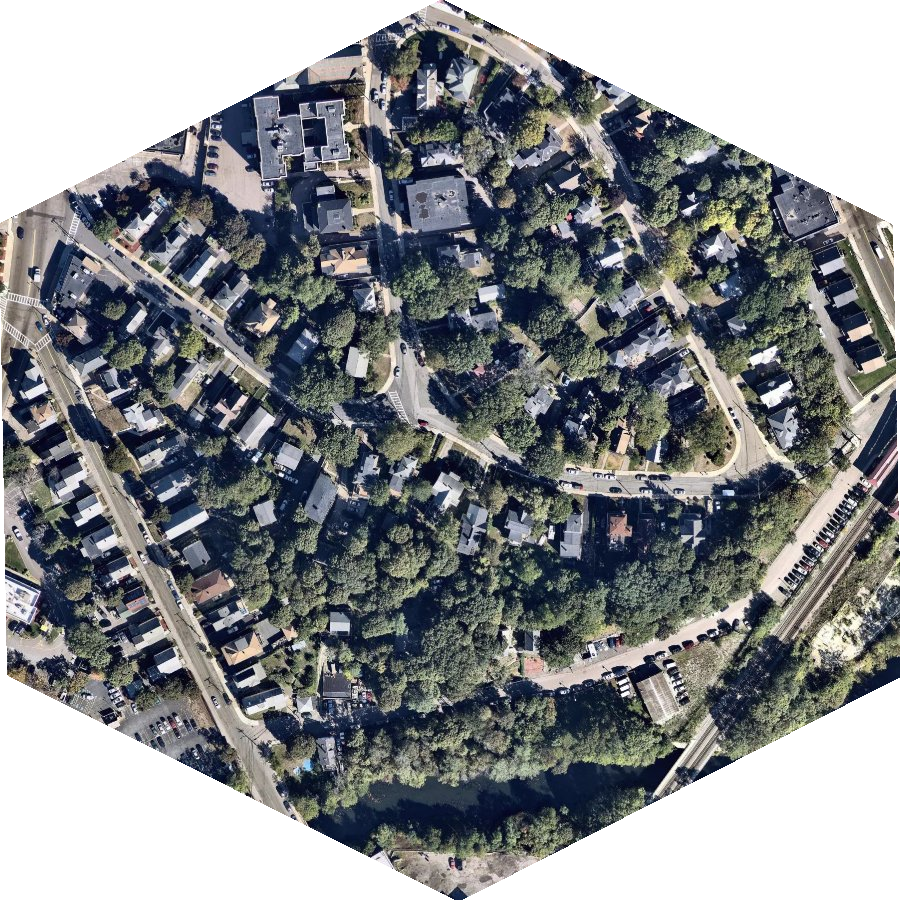

In [13]:
from IPython.display import Image
import sys

sys.path.append("/Users/max/Development/green-last-mile/h3-images")
from generate_image import run


run(hex_low, "satellite-v9", tile_res=900, output=ROOT / "out" / "service_time_low.png")
# load the image and show it
Image(filename=ROOT / "out" / "service_time_low.png")

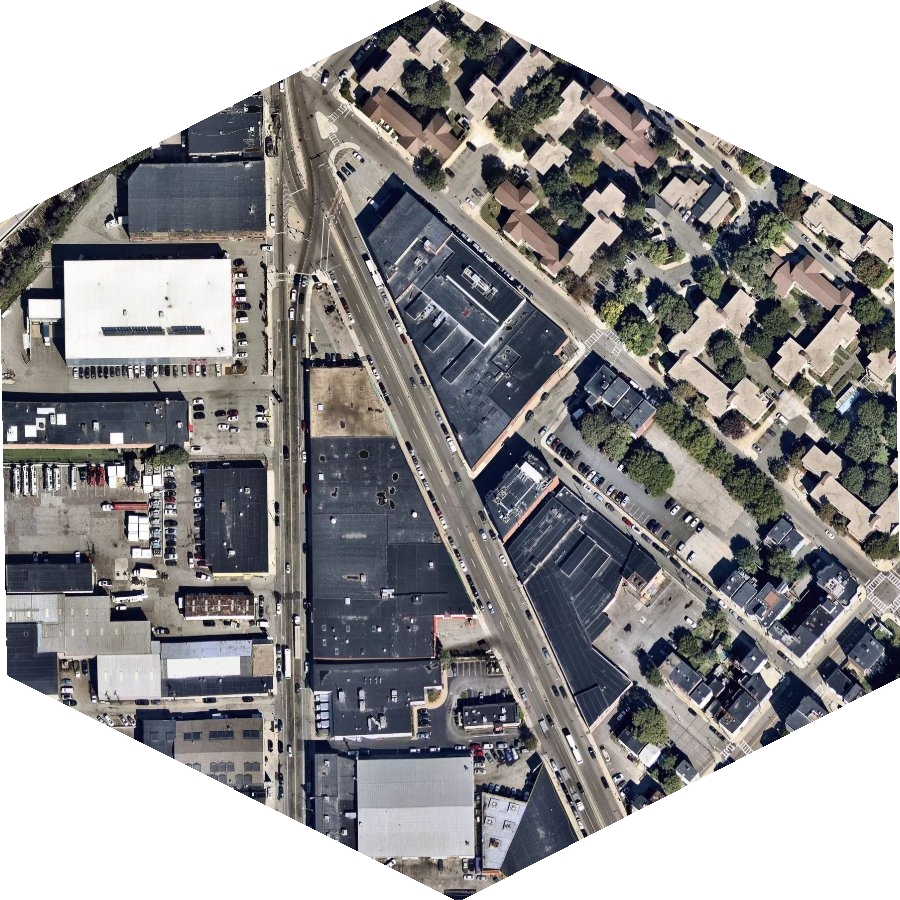

In [14]:
run(hex_med, "satellite-v9", tile_res=900, output=ROOT / "out" / "service_time_med.png")
# load the image and show it
Image(filename=ROOT / "out" / "service_time_med.png")

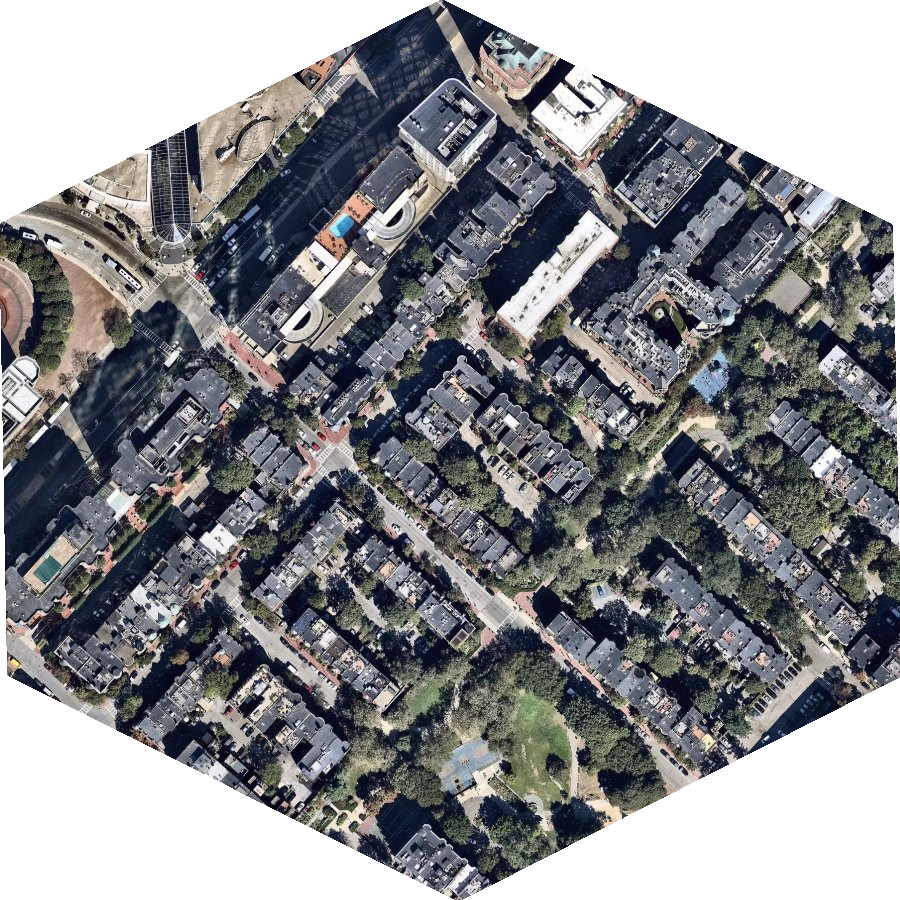

In [15]:
run(
    hex_high,
    "satellite-v8",
    tile_res=900,
    output=ROOT / "out" / "service_time_high.png",
)
# load the image and show it
Image(filename=ROOT / "out" / "service_time_high.png")

## Plot the KDE of the Three Hexes


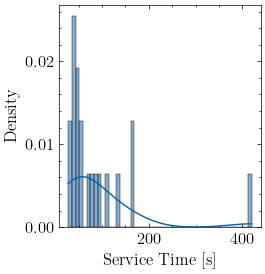

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(
    [
        "science",
    ]
)


plot_df = service_time_df.filter(
    pl.col("region_id").is_in(
        [
            hex_low,
        ]
    )
)

fig, ax = plt.subplots(figsize=(3, 3))

sns.histplot(
    plot_df.to_pandas(),
    x="service_time",
    stat="density",
    ax=ax,
    bins=50,
    # fill=False,
    # linewidth=2,
    kde=True,
)

ax.set_xlabel("Service Time [s]")
ax.set_ylabel("Density")

fig.tight_layout()
# update the text size
plt.rcParams.update({"font.size": 15})

In [29]:
px.colors.diverging.Tealrose_r[0]

'rgb(208, 88, 126)'

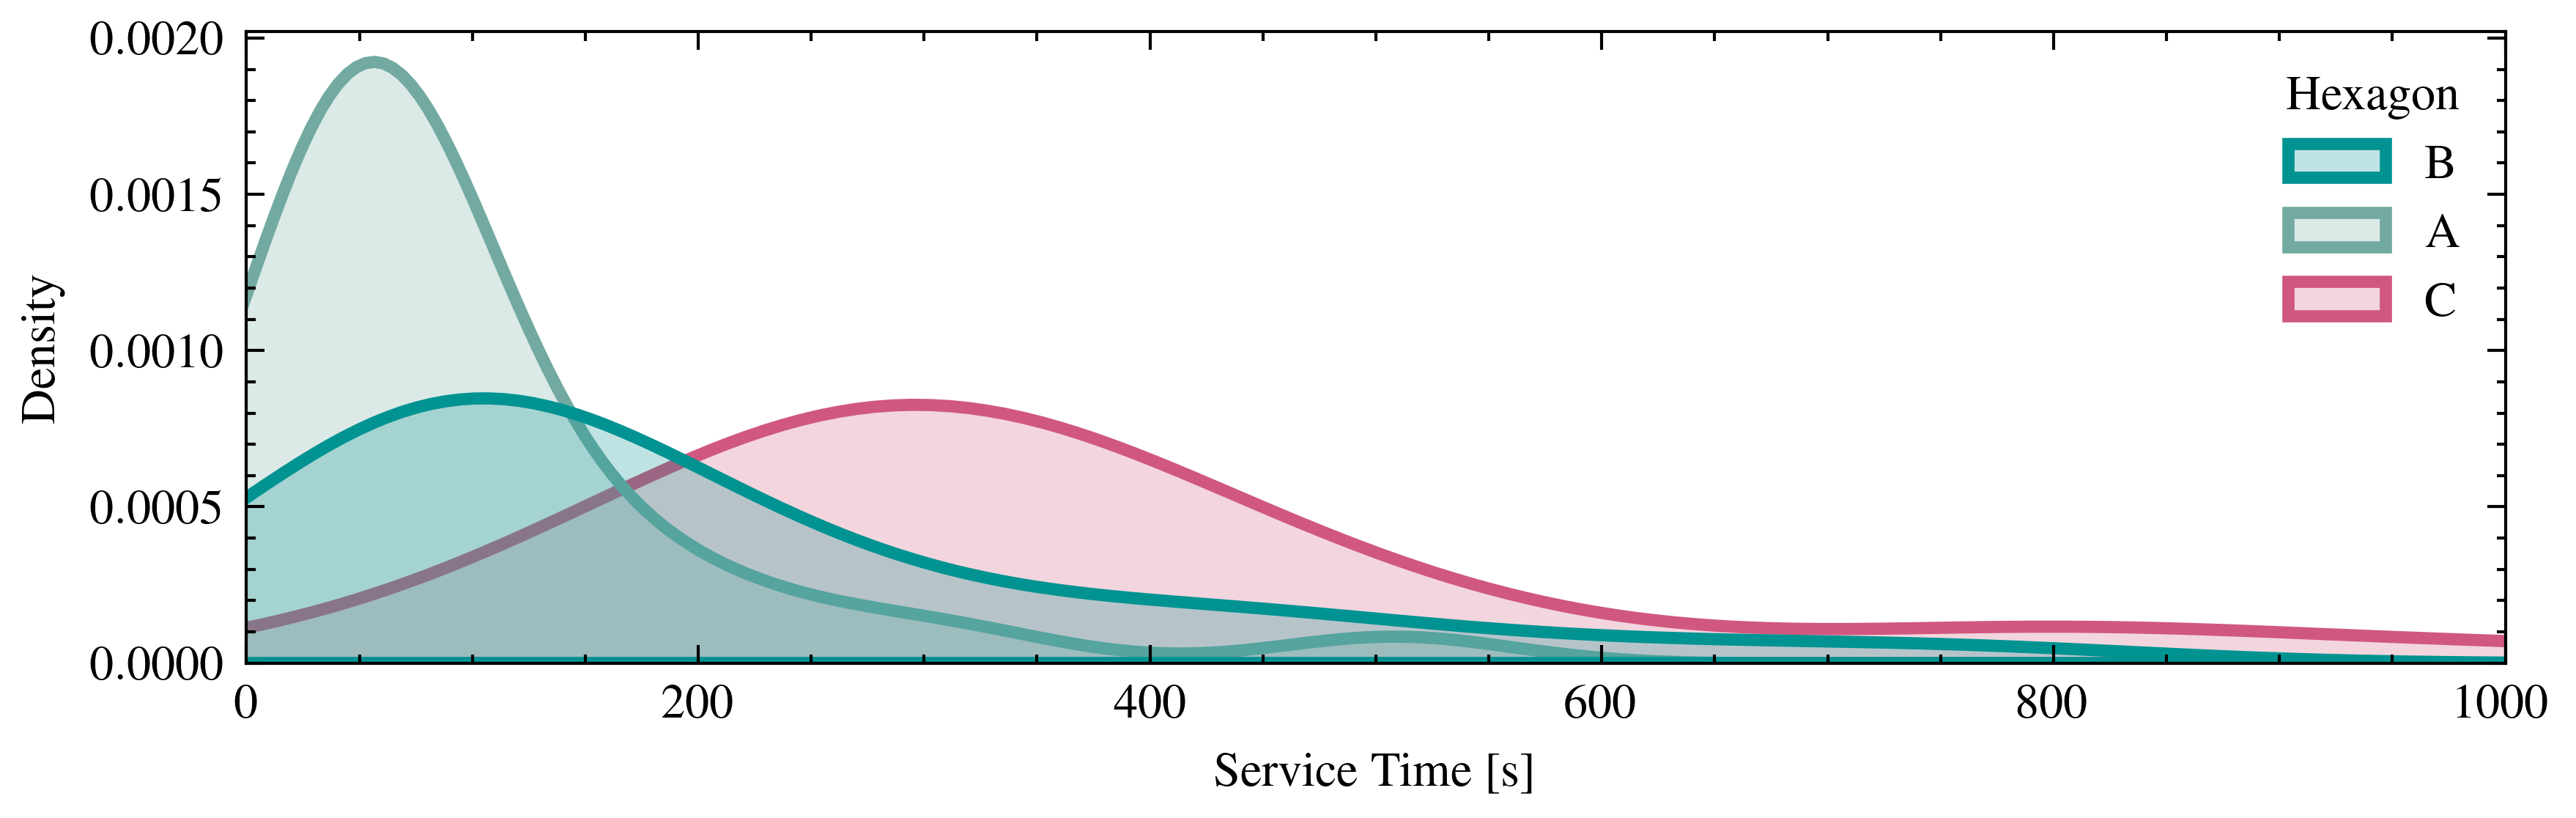

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots

plt.style.use(["science", "ieee"])


plot_df = service_time_df.filter(
    pl.col("region_id").is_in(
        [
            hex_low,
            hex_med,
            hex_high,
        ]
    )
).with_columns(
    pl.col("region_id").replace(
        {
            hex_low: "A",
            hex_med: "B",
            hex_high: "C",
        }
    )
).rename({"region_id": "Hexagon"})

fig, ax = plt.subplots(figsize=(6, 2))


colors, _ = px.colors.convert_colors_to_same_type(
    px.colors.diverging.Tealrose_r, colortype="tuple"
)

# sns.histplot(
#     plot_df.to_pandas(),
#     x="service_time",
#     stat="density",
#     hue="region_id",
#     ax=ax,
#     bins=50,
#     kde=True,
#     palette=(
#         colors[-1],
#         colors[5],
#         colors[0],
#     ),
# )

# just show filled KDEs
sns.kdeplot(
    plot_df.to_pandas(),
    x="service_time",
    hue="Hexagon",
    linewidth=2,
    common_norm=True,
    fill=True,
    palette=(
        colors[-1],
        colors[5],
        colors[0],
    ),
)



ax.set_xlabel("Service Time [s]")
ax.set_ylabel("Density")

# set range to be the same
ax.set_xlim(0, 1000)

fig.tight_layout()
# update the text size